# Instructions
Run each of the following cells in order to generate an svg of a warped grid puzzle. <br/>
If you change any parameters, rerun the algorithm for generating the puzzle. <br/>
If you change the transformation, you only have to rerun the cell for plotting. 

In [27]:
# Libraries used
import matplotlib.pyplot as plt
import numpy as np
import random

In [28]:
# Parameters
nIts = 200
partitionCountHor = 1
partitionCountVert = 1
graphWidth = partitionCountHor*6
graphHeight = partitionCountVert*6

In [ ]:
# The contents of this cell should only be edited if you are trying to make changes to the algorithm that generates the puzzle. 

# Returns whether a piece is adjacent to another partition
def interiorPiece(partition, eater):
    return leftInterior(partition, eater) and rightInterior(partition, eater) and topInterior(partition,eater) and botInterior(partition,eater)

def leftInterior(partition, eater):
    return [eater[0]-1,eater[1]] in partition or eater[0]==0

def rightInterior(partition, eater):
    return [eater[0]+1,eater[1]] in partition or eater[0]==graphWidth-1

def topInterior(partition, eater):
    return [eater[0],eater[1]+1] in partition or eater[1]==graphHeight-1

def botInterior(partition, eater):
    return [eater[0],eater[1]-1] in partition or eater[1]==0

# Returns whether a piece is adjacent to the boundary of the entire puzzle.
# This is used to keep the partitions on the boundary from eating partitions too much
def boundaryPiece(eater):
    return eater[0]==graphWidth or eater[0]==0 or eater[1]==graphHeight-1 or eater[1]==0

# Returns whether the piece attempting to be eaten falls within the boundary of the entire puzzle. 
def eatenNotInRange(eaten):
    return eaten[0] < 0 or eaten[1] < 0 or \
           eaten[0] > graphWidth-1 or eaten[1] > graphHeight -1

# Using a local check, this returns whether eating a given piece will break a partition into two 
# nonconnected regions. 
def noBreak(eatenPartition, eaten):

    # Protects pieces from getting too small
    if len(eatenPartition) < 6:
        return False
    
    UL = [eaten[0]-1,eaten[1]+1] in eatenPartition
    U =  [eaten[0],eaten[1]+1] in eatenPartition
    UR = [eaten[0]+1,eaten[1]+1] in eatenPartition
    L =  [eaten[0]-1,eaten[1]] in eatenPartition
    R =  [eaten[0]+1,eaten[1]] in eatenPartition
    BL = [eaten[0]-1,eaten[1]-1] in eatenPartition
    B =  [eaten[0],eaten[1]-1] in eatenPartition
    BR = [eaten[0]+1,eaten[1]-1] in eatenPartition

    topRowAllIn   = UL and U and UR 
    botRowAllIn   = BL and B and BR 
    leftColAllIn  = UL and L and BL 
    rightColAllIn = UR and R and BR 
    topRowAllGone   = not(UL or U or UR )
    botRowAllGone   = not(BL or B or BR )
    leftColAllGone  = not(UL or L or BL )
    rightColAllGone = not(UR or R or BR )
    
    # exceptions:
    square = (topRowAllGone and leftColAllGone and BR) or \
             (topRowAllGone and rightColAllGone and BL) or \
             (botRowAllGone and leftColAllGone and UR) or \
             (botRowAllGone and rightColAllGone and UL)
    
    tPiece = (topRowAllGone and not L and not R and B) or \
             (botRowAllGone and not L and not R and U) or \
             (leftColAllGone and not U and not B and R) or \
             (rightColAllGone and not U and not B and L)
    
    rectPiece = (botRowAllIn and   L and R) or \
                (topRowAllIn and   L and R) or \
                (rightColAllIn and U and B) or \
                (leftColAllIn and  U and B)
    
    lPiece = (topRowAllGone and leftColAllGone and not BR and B and R) or \
             (topRowAllGone and rightColAllGone and not BL and B and L) or \
             (botRowAllGone and leftColAllGone and not UR and U and R) or \
             (botRowAllGone and rightColAllGone and not UL and U and L)

    if lPiece:
        return False
    
    if square or tPiece or rectPiece:
        return True
    
    # rule:
    if (not topRowAllIn and not botRowAllIn and not leftColAllGone and not rightColAllGone) or \
       (not leftColAllIn and not rightColAllIn and not topRowAllGone and not botRowAllGone):
        return False

    return True

# checks whether a square will be made in the partition of the eater by eating
def noSquare(partition, eaten):
    UL = [eaten[0]-1,eaten[1]+1] in partition
    U =  [eaten[0],eaten[1]+1] in partition
    UR = [eaten[0]+1,eaten[1]+1] in partition
    L =  [eaten[0]-1,eaten[1]] in partition
    R =  [eaten[0]+1,eaten[1]] in partition
    BL = [eaten[0]-1,eaten[1]-1] in partition
    B =  [eaten[0],eaten[1]-1] in partition
    BR = [eaten[0]+1,eaten[1]-1] in partition
    topRowAllGone   = not(UL or U or UR )
    botRowAllGone   = not(BL or B or BR )
    leftColAllGone  = not(UL or L or BL )
    rightColAllGone = not(UR or R or BR )

    return not (R and BR and B) and \
           not (L and BL and L) and \
           not (R and UR and U) and \
           not (L and UL and U)
# End functions

def generatePuzzle(partitionCountHor, partitionCountVert, graphWidth, graphHeight, nIts):
    # Generates rectangular partitions
    partitionWidth = int(graphWidth/partitionCountHor)
    partitionHeight = int(graphHeight/partitionCountVert)
    partitions = []
    
    for i in range(partitionCountHor):
        for j in range(partitionCountVert):
            x,y =np.meshgrid(np.array(list(range(partitionWidth)))+i*partitionWidth,np.array(list(range(partitionHeight)))+j*partitionHeight)
            partitions.append(list(zip(x.ravel(),y.ravel())))
    
    # Sets coordinates in partitions as lists.  The above populates coordinates at tuples,
    # which make slice indexing difficult. 
    for partition in partitions:
        for i in range(len(partition)):
            partition[i] = list(partition[i])
            
    # return if there is only one partition
    if(len(partitions) == 1):
        return partitions
    
    print("Progress:")
    # The algorithm for partitions pseudorandomly eating into each other. 
    for i in range(nIts):
        if (i+1) % (nIts//10) == 0:
            print(str(i+1)+"/"+str(nIts))
        for partition in partitions:
            eater = partition[random.randint(0,len(partition)-1)]
            eatFlag = False 
            counter = 0
            
            while not eatFlag and counter < len(partition) and not (eater[0]==graphWidth or eater[0]==0 or eater[1]==graphHeight-1 or eater[1]==0):
                
                while interiorPiece(partition,eater) and counter < len(partition):
                    eater = partition[random.randint(0,len(partition)-1)]
            
                eatables = [[eater[0]+1,eater[1]],[eater[0]-1,eater[1]],[eater[0],eater[1]+1],[eater[0],eater[1]-1]]
    
                eaten = eatables[random.randint(0,len(eatables)-1)]
                while eatenNotInRange(eaten) or eaten in partition:
                    eaten = eatables[random.randint(0,len(eatables)-1)]
    
                for eatenPartition in partitions:
                    if eaten in eatenPartition:
                        break
    
                if noBreak(eatenPartition,eaten) and noSquare(partition,eaten):
                    eatenPartition.remove(eaten)
                    partition.append(eaten)
                    eatFlag = True
                counter = counter+1
    print("Puzzle generated.")
    return partitions

In [30]:
# Mobius transformation with a squiggle
def transformedx(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    a ,b ,c ,d  = 2, 0.01, .03, 1

    # Transformation in x
    x = x+.5*np.cos(1.5*y) #squiggle
    x = (a*c*(x**2+y**2)+(a*d+b*c)*x+b*d)/((c*x+d)**2+(c*y)**2) # mobius transformation in x
    return x
    

def transformedy(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    a ,b ,c ,d  = 2, 0.01, .03, 1

    # Transformation in y
    y = ((a*d-b*c)*y)/((c*x+d)**2+(c*y)**2)
    return y


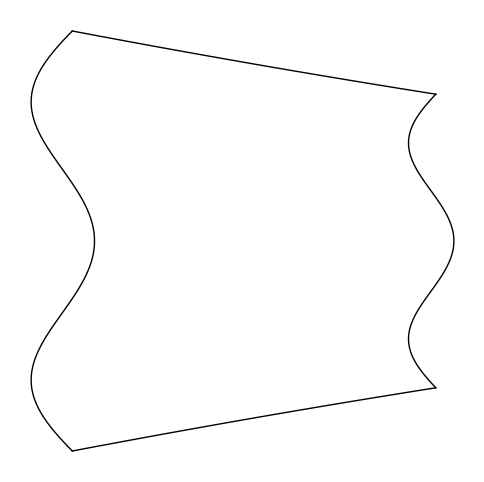

In [32]:
# call function to generate puzzle
partitions = generatePuzzle(partitionCountHor, partitionCountVert, graphWidth, graphHeight, nIts)

# Plotting
plt.figure(figsize=(6,6), dpi=100)
for partition in partitions:
    for piece in partition:
        if not leftInterior(partition, piece):
            x = np.linspace(piece[0]-.5,piece[0]-.5,100)
            y = np.linspace(piece[1]-.5,piece[1]+.5,100)
            plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)
        if not topInterior(partition, piece):
            x = np.linspace(piece[0]-.5,piece[0]+.5,100)
            y = np.linspace(piece[1]+.5,piece[1]+.5,100)
            plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)

x = np.linspace(0-.5,0-.5,100)
y = np.linspace(0-.5,graphHeight-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)

x = np.linspace(0-.5,graphWidth-.5,100)
y = np.linspace(graphHeight-.5,graphHeight-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)


x = np.linspace(graphWidth-.5,graphWidth-.5,100)
y = np.linspace(graphHeight-.5,0-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)


x = np.linspace(graphWidth-.5,0-.5,100)
y = np.linspace(0-.5,0-.5,100)
plt.plot(transformedx(x,y),transformedy(x,y),color="black",linewidth=1)

plt.axis("off")
plt.show()


In [ ]:
#Run this to save your image
#plt.savefig("mobiusSquiggle.svg", format="svg")

# Additional transformations

Try putting together the transformations below to make your own puzzle! <br/>
To see what each transformation does, run one of the cells below, and then plot. <br/>
If you want to save your puzzle, remember to change the name of the file before saving. 

Bubble:
$$f(x,y)=\left\{\begin{array}{ccc}(1+\frac{a}b-\frac{r}b)\cdot(x,y)&,&r<a\\
                                   (x,y)&,&r\geq a
                                   \end{array}\right.$$
where $r=\sqrt{x^2+y^2}$. <br/>
Notice that when $r=a$, $\frac{a}b-\frac{r}b=0$, which is necessary for making this function continuous. <br/>
The larger $\frac{a}b$ is, the more "pushed out" points near $r=0$ become as a result of this transformation. 

In [ ]:
# Bubble
def transformedx(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    r = np.sqrt(x**2+y**2)

    # Transformation in x
    # Weird stuff happens to the puzzle when cutoff > curviness
    cutoff = 14
    curviness = 15 # the closer this is to the cutoff, the more curvy
    return x*(1+cutoff/curviness-(r/curviness)*(r<cutoff)-(r>=cutoff)*cutoff/curviness)
    

def transformedy(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    r = np.sqrt(x**2+y**2)

    # Transformation in y
    # Weird stuff happens to the puzzle when cutoff > curviness
    cutoff = 14
    curviness = 15 # the closer this is to the cutoff, the more curvy
    return y*(1+cutoff/curviness-(r/curviness)*(r<cutoff)-(r>=cutoff)*cutoff/curviness)


Reverse Bubble:
$$f(x,y)=\left\{\begin{array}{ccc}\frac{(x,y)}{1+\frac{a}b-\frac{r}b}&,&r<a\\
                                   (x,y)&,&r\geq a
                                   \end{array}\right.$$
where $r=\sqrt{x^2+y^2}$. <br/>
This is the same as the bubble transformation, except we divide $1+\frac{a}b-\frac{r}b$ instead of multiplying it. 

In [ ]:
# Reverse bubble
def transformedx(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    r = np.sqrt(x**2+y**2)

    # Transformation in x
    # Weird stuff happens to the puzzle when cutoff > curviness
    cutoff = 14
    curviness = 14.1 # the lower this variable, the more curvy
    return x/(1+cutoff/curviness-(r/curviness)*(r<cutoff)-(r>=cutoff)*cutoff/curviness)
    

def transformedy(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    r = np.sqrt(x**2+y**2)

    # Transformation in y
    # Weird stuff happens to the puzzle when cutoff > curviness
    cutoff = 14
    curviness = 14.1 # the lower this variable, the more curvy
    return y/(1+cutoff/curviness-(r/curviness)*(r<cutoff)-(r>=cutoff)*cutoff/curviness)


Squiggles:
$$f(x,y)=(x+a\cos(by),y+c\cos(dx))$$
Varying $a$ and $c$ change the amplitude of the squiggles, and varying $b$ and $d$ change the frequencies. 

In [ ]:
# Squiggles
def transformedx(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery

    return x+.5*np.cos(y)
    

def transformedy(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery

    return y+.5*np.cos(x/2)


Möbius transformation:
$$f(z)=\frac{az+b}{cz+d}$$
where $z=x+bi$. <br/>
Converting this from complex numbers to cartesian coordinates is complicated, but this has been done in the functions below. <br/>
Möbius transformations can be sensitive to their parameters in somewhat unintuitive ways, so keep note of parameter combinations you like. 

In [ ]:
# Mobius transformation 
def transformedx(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    a ,b ,c ,d  = 2, 0.01, .03, 1

    # Transformation in x
    x = (a*c*(x**2+y**2)+(a*d+b*c)*x+b*d)/((c*x+d)**2+(c*y)**2) 
    return x
    

def transformedy(x,y):
    centerx = graphWidth/2-.5
    centery = graphHeight/2-.5
    x = x-centerx
    y = y-centery
    a ,b ,c ,d  = 2, 0.01, .03, 1

    # Transformation in y
    y = ((a*d-b*c)*y)/((c*x+d)**2+(c*y)**2)
    return y
